In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

def add_to_path(lib_dir):
    if lib_dir not in sys.path:
        sys.path.insert(0, lib_dir)
        
add_to_path('src')

In [25]:
import tensorflow as tf
from src.model import Generator, Discriminator

from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import IPython.display as display
from PIL import Image
import math


AUTOTUNE = tf.data.experimental.AUTOTUNE
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
train_dir = os.path.join('/home/samenabar/storage/code/HoloGAN/one_image_dataset/')

In [8]:
num_tr = len(os.listdir(train_dir))
print('num_tr', num_tr)
BATCH_SIZE = 64
IMG_HEIGHT = 64
IMG_WIDTH = 64

num_tr 1


In [10]:
from data_utils import process_path

In [13]:
list_ds_train = tf.data.Dataset.list_files(os.path.join(train_dir, '*.png'))
map_fn = lambda x: process_path(x, IMG_HEIGHT, IMG_WIDTH)
labeled_ds = list_ds_train.map(
    map_fn, num_parallel_calls=AUTOTUNE)

for image in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)

Image shape:  (64, 64, 3)


In [15]:
from data_utils import prepare_for_training

In [17]:
train_ds = prepare_for_training(labeled_ds, 1)
# for _ in tqdm(train_ds, total=int(math.ceil(num_tr / BATCH_SIZE))):
#     pass

In [20]:
from data_utils import show_batch

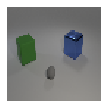

In [22]:
image_batch = next(iter(train_ds))
show_batch(image_batch.numpy());

In [75]:
z_bg = tf.random.uniform((selected_batch.shape[0], generator.z_dim_bg), minval=-1, maxval=1)

num_objs = [3, 4, 4, 4, 4, 3, 4, 3, 4]
tensors = []
max_len = max(num_objs)
for no in num_objs:
    _t = tf.random.uniform((no, generator.z_dim_fg), minval=-1, maxval=1)
    _z = tf.zeros((max_len - no, generator.z_dim_fg), dtype=tf.float32)
    _t = tf.concat((_t, _z), axis=0)
    tensors.append(_t)
z_fg = tf.stack(tensors, axis=0)

In [34]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = bce(tf.ones_like(real), real)
    generated_loss = bce(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

def generator_loss(generated):
    return bce(tf.ones_like(generated), generated)

In [39]:
### OVERFIT TO DATA

generator = Generator(z_dim_bg=64, z_dim_fg=128)
discriminator = Discriminator()

generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)

total_g_loss = 0.
total_d_loss = 0.

num_steps = 5000
pbar = tqdm(range(num_steps), total=num_steps)

for it in pbar:

    with tf.GradientTape(persistent=True) as tape:
        generated = generator(tf.ones((1, 64)), None)

        d_fake_logits = discriminator(generated)
        real_input = (image_batch * 2) - 1
        # real_input = ((image_batch * 2) - 1) + tf.random.normal(image_batch.shape, stddev=.02)
        d_real_logits = discriminator(real_input)

        d_loss = discriminator_loss(d_real_logits, d_fake_logits)
        g_loss = generator_loss(d_fake_logits)

    d_variables = discriminator.trainable_variables
    d_gradients = tape.gradient(d_loss, d_variables)
    discriminator_optimizer.apply_gradients(zip(d_gradients, d_variables))

    g_variables = generator.trainable_variables
    g_gradients = tape.gradient(g_loss, g_variables)
    generator_optimizer.apply_gradients(zip(g_gradients, g_variables))

    total_d_loss += d_loss.numpy()
    total_g_loss += g_loss.numpy()

    pbar.set_postfix(g_loss=f'{g_loss.numpy():.4f} ({total_g_loss / (it + 1):.4f})',
                     d_loss=f'{d_loss.numpy():.4f} ({total_d_loss / (it + 1):.4f})')
    # break

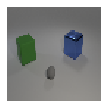

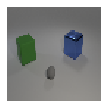

In [40]:
show_batch(image_batch)

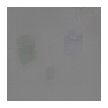

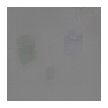

In [36]:
show_batch((generated + 1) / 2)

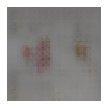

In [110]:
_generated = generator(
    tf.random.uniform((1, 30), minval=-1, maxval=1),
    tf.random.uniform((1, 2, 90), minval=-1, maxval=1),
)
show_batch((_generated + 1) / 2)

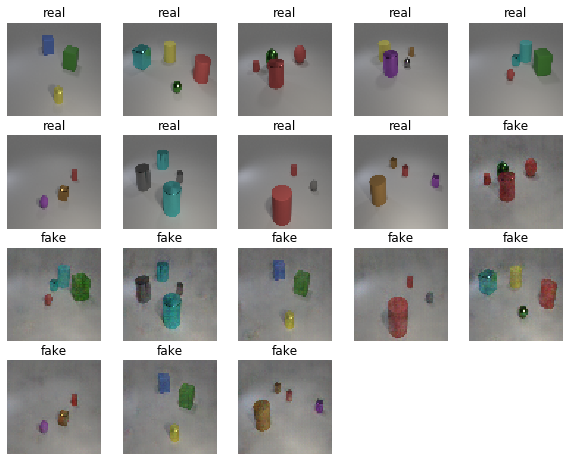

In [93]:
show_batch(tf.concat((selected_batch, (generated + 1) / 2), axis=0), labels=['real'] * 9 + ['fake'] * 9)

In [114]:
tf.random.uniform((64,),minval=3, maxval=min(10, 5 + 2 * 0), dtype=tf.int32)

<tf.Tensor: shape=(64,), dtype=int32, numpy=
array([4, 3, 4, 4, 4, 4, 3, 3, 4, 3, 3, 4, 3, 4, 3, 4, 3, 4, 4, 3, 3, 3,
       4, 3, 3, 4, 4, 3, 4, 3, 3, 4, 4, 3, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4,
       4, 4, 4, 4, 3, 4, 3, 4, 4, 3, 3, 3, 3, 3, 4, 3, 3, 4, 4, 4],
      dtype=int32)>

In [14]:
import datetime

In [27]:
log_dir = "HoloGAN/log/" + datetime.datetime.now().strftime("%Y%m%d-%H-%M-%S")
summary_writer = tf.summary.create_file_writer(log_dir)

In [22]:
str(discriminator)

[autoreload of src.model failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 434, in superreload
    module = reload(module)
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/sebamenabar/Documents/repos/HoloGAN/src/model.py", line 13, in <module>
    from layers impo

'<src.model.Discriminator object at 0x137c07790>'

In [ ]:
### TRAIN ON DATASET

# LOGGING

# generator = Generator()
# discriminator = Discriminator()

generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)

bce = K.losses.BinaryCrossentropy(from_logits=True)

# num_steps = 1000
# pbar = tqdm(enumerate(train_ds), total=num_tr // BATCH_SIZE)

total_g_loss = 0.
total_d_loss = 0.

with summary_writer.as_default():
    total_it = 0
    total_g_loss = 0.
    total_d_loss = 0.
    counter = 1
    
    for epoch in range(25):
        train_ds = prepare_for_training(labeled_ds)
        pbar = tqdm(enumerate(train_ds), total=int(math.ceil(num_tr / BATCH_SIZE)))

        for it, image_batch in pbar:
            bsz = image_batch.shape[0]

            with tf.GradientTape(persistent=True) as tape:
                # generated random noise
                z_bg = tf.random.uniform((bsz, generator.z_dim_bg), minval=-1, maxval=1)
                num_objs = tf.random.uniform((bsz,), minval=3, maxval=min(10, 5 + 2 * epoch), dtype=tf.int32)
                tensors = []
                max_len = max(num_objs)
                for no in num_objs:
                    _t = tf.random.uniform((no, generator.z_dim_fg), minval=-1, maxval=1)
                    _z = tf.zeros((max_len - no, generator.z_dim_fg), dtype=tf.float32)
                    _t = tf.concat((_t, _z), axis=0)
                    tensors.append(_t)
                z_fg = tf.stack(tensors, axis=0)

                # fake img
                generated = generator(z_bg, z_fg)

                d_fake_logits = discriminator(generated)
                d_real_logits = discriminator(((image_batch * 2) - 1) + tf.random.normal(image_batch.shape, stddev=.02))

                d_loss = discriminator_loss(d_real_logits, d_fake_logits)
                g_loss = generator_loss(d_fake_logits)

            d_variables = discriminator.trainable_variables
            d_gradients = tape.gradient(d_loss, d_variables)
            discriminator_optimizer.apply_gradients(zip(d_gradients, d_variables))

            g_variables = generator.trainable_variables
            g_gradients = tape.gradient(g_loss, g_variables)
            generator_optimizer.apply_gradients(zip(g_gradients, g_variables))

            total_d_loss += d_loss.numpy()
            total_g_loss += g_loss.numpy()

            pbar.set_postfix(g_loss=f'{g_loss.numpy():.4f} ({total_g_loss / (counter):.4f})',
                             d_loss=f'{d_loss.numpy():.4f} ({total_d_loss / (counter):.4f})')

            if total_it % 100 == 0:
                print('AAAH')
                tf.summary.scalar('losses/d_loss', total_d_loss / counter, step=total_it + 1)
                tf.summary.scalar('losses/g_loss', total_g_loss / counter, step=total_it + 1)
                tf.summary.image(f'generated_{epoch}-{it}.jpg', (generated + 1) / 2, step=total_it, max_outputs=8)
                
                total_g_loss = 0.
                total_d_loss = 0.
                counter = 1
                tf.summary.flush()
                
            total_it += 1
            counter += 1

            # break

AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH



AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH



AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH



AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH



AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH



AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH



AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH



AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH



AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH



AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH



AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH



AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH



AAAH
AAAH
AAAH
AAAH


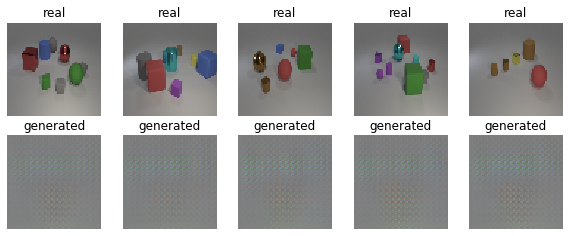

In [18]:
show_batch(tf.concat((image_batch[:5], (generated[:5] + 1.) / 2), axis=0), ['real'] * 5 + ['generated'] * 5)

In [108]:
iter(train_ds).__dict__

{'_device': '',
 '_dataset': <_ModelDataset shapes: (None, 64, 64, 3), types: tf.float32>,
 '_element_spec': TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None),
 '_flat_output_types': [tf.float32],
 '_flat_output_shapes': [TensorShape([None, 64, 64, 3])],
 '_iterator_resource': <tf.Tensor: shape=(), dtype=resource, numpy=<unprintable>>,
 '_deleter': <tf.Tensor: shape=(), dtype=variant, numpy=<unprintable>>,
 '_resource_deleter': <tensorflow.python.data.ops.iterator_ops.IteratorResourceDeleter at 0x7f3e23015048>}

In [119]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.
